pip install numpy 

pip install opencv-python

pip install tensorflow

pip install pygame

pip install pillow

pip install matplotlib


In [ ]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
import cv2
import time
import pygame  # 引入 pygame 以播放音效
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image

### 只能用輸入為48 X 48 的模型

In [ ]:

model_path1 = "model_3.h5"

model = tf.keras.models.load_model(model_path1)
print(f"Model loaded from: {model_path1}")
print(f"Expected input shape: {model.input_shape}")
pixel = model.input_shape[2]
print(f"Expected input size: {pixel}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    MaxPooling2D,
    Dropout,
    GlobalAveragePooling2D,
    Dense
)
from tensorflow.keras.models import Model


class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


input_shape = (48, 48, 1)  # 灰度图像

def create_model():
    inputs = tf.keras.Input(shape=input_shape)


    x = Conv2D(32, kernel_size=(3, 3), activation='relu', name="conv_1")(inputs)
    x = BatchNormalization()(x)

    x = Conv2D(64, kernel_size=(3, 3), activation='relu', name="conv_2")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)

    x = Conv2D(128, kernel_size=(3, 3), activation='relu', name="conv_3")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)

    x = Conv2D(256, kernel_size=(3, 3), activation='relu', name="conv_4")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)

    # 使用全局平均池化代替 Flatten
    x = GlobalAveragePooling2D()(x)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)


    outputs = Dense(len(class_labels), activation='softmax')(x)


    model = Model(inputs=inputs, outputs=outputs)

    return model


model = create_model()

model.load_weights(model_path1)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


### 上傳音檔

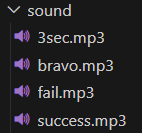

In [49]:

# 初始化音效
pygame.mixer.init()
success_sound = pygame.mixer.Sound('sound/success.mp3')  
fail_sound = pygame.mixer.Sound('sound/fail.mp3')        
countdown_sound = pygame.mixer.Sound('sound/3sec.mp3')   



### 上傳inside out 角色圖片
在本地端加上一個資料夾 images
下面放七張png
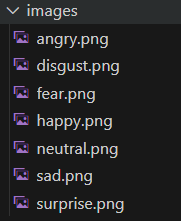

In [ ]:

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
emotion_colors = {
    'Angry': (0, 0, 255),       # 紅色
    'Disgust': (0, 255, 0),     # 綠色
    'Fear':  (128, 0, 128),        # 灰色
    'Happy': (0, 255, 255),     # 黃色
    'Neutral': (128, 128, 128), # 灰色
    'Sad':(255, 0, 0),       # 藍色
    'Surprise': (180, 105, 255) # 粉色 
}


emotion_images = {
    'Angry': 'images/angry.png',
    'Disgust': 'images/disgust.png',
    'Fear': 'images/fear.png',
    'Happy': 'images/happy.png',
    'Neutral': 'images/neutral.png',
    'Sad': 'images/sad.png',
    'Surprise': 'images/surprise.png'
}


emotion_icons = {label: cv2.imread(path, cv2.IMREAD_UNCHANGED) for label, path in emotion_images.items()}
emotion_icons = {}
for label, path in emotion_images.items():
    icon = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if icon is None:
        print(f"Error: Unable to load image for '{label}' from '{path}'. Please check the file path.")
    else:
        emotion_icons[label] = icon
        print(f"Success: Loaded image for '{label}' from '{path}'.")

In [51]:
def generate_grad_cam(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=[model.input],
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # 計算梯度
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 加權特徵圖
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # 標準化熱力圖
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [52]:

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


In [53]:

# 遊戲參數
target_emotion = None 
game_timer = None 
game_duration = 10 
feedback_message = ""  
score = 0  
frame_count = 0
predict_frequency = 20  # 每隔20帪數 預測

In [54]:

cap = cv2.VideoCapture(0)

last_emotion = "Neutral"
last_probabilities = np.zeros(len(emotion_labels))


def predict_emotion_with_probabilities(face, model):
    """預測人臉"""
    face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    resized_face = cv2.resize(face_gray, (48, 48)) / 255.0  
    face_img = np.expand_dims(resized_face, axis=(0, -1))  # 增加 batch 和 channel 维度
    predictions = model.predict(face_img)
    return predictions[0]
# def predict_emotion_with_probabilities(face, model):
#     """預測人臉"""
#     if len(face.shape) == 3:  # 如果輸入圖像有多通道
#         face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)  # 轉為灰度
#     else:
#         face_gray = face  # 已是灰度圖，直接使用

#     resized_face = cv2.resize(face_gray, (48, 48)) / 255.0  # 調整大小並歸一化
#     face_img = np.expand_dims(resized_face, axis=(0, -1))  # 增加 batch 和 channel 維度
#     probabilities = model.predict(face_img)  # 模型預測
#     return probabilities[0]  # 返回每個情緒的概率


def overlay_image(background, overlay, x, y):
    """在背景上叠加圖片"""
    h, w, channels = overlay.shape
    bg_h, bg_w, _ = background.shape

    if y + h > bg_h or x + w > bg_w:
        return background 

    
    if channels == 4:
        alpha = overlay[:, :, 3] / 255.0  
    else:
        alpha = np.ones((h, w), dtype=np.float32)

    for c in range(3):
        background[y:y+h, x:x+w, c] = (
            overlay[:, :, c] * alpha +
            background[y:y+h, x:x+w, c] * (1 - alpha)
        )ckground
    return ba

In [ ]:
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 初始化遊戲邏輯
    if game_timer is None:
        previous_emotion = target_emotion  # 記錄上一輪的目標表情
        while True:
            target_emotion = random.choice(emotion_labels)  # 隨機選擇新的目標表情
            if target_emotion != previous_emotion:  # 確保新目標表情與上一輪不同
                break
        game_timer = time.time() 
        feedback_message = ""  
        countdown_triggered = False  

    frame_count += 1 


    faces = face_cascade.detectMultiScale(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        face = frame[y:y + h, x:x + w]
        
        gray_face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)  # 如果是 BGR，轉換為灰度
        face_resized = cv2.resize(gray_face, (48, 48)) / 255.0 
        face_array = np.expand_dims(face_resized, axis=-1).astype("float32") 
        face_array = np.expand_dims(face_array, axis=0)  # 增加批次維度


        if frame_count % predict_frequency == 0:  # 每隔 `predict_frequency` 幀進行一次預測
            probabilities = predict_emotion_with_probabilities(face, model)  # 預測情緒概率
            last_probabilities = probabilities
            max_prob_idx = np.argmax(probabilities)   
            highest_prob = probabilities[max_prob_idx]
            last_emotion = emotion_labels[max_prob_idx]  
        else:
            probabilities = last_probabilities  
            highest_prob = np.max(probabilities) if probabilities is not None else 0

        # 顯示用戶的當前情緒
        cv2.putText(frame, f"Your Emotion: {last_emotion}", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x + w, y + h), emotion_colors.get(last_emotion, (255, 255, 255)), 2)

        
        if last_emotion == target_emotion:  # 答對
            feedback_message = "Correct! Great Job!"
            score += 10
            pygame.mixer.Sound.play(success_sound)
            game_timer = None  # 重置計時器

            # 使用 Grad-CAM 生成熱力圖
            face_resized = cv2.resize(cv2.cvtColor(face, cv2.COLOR_BGR2GRAY), (48, 48)) / 255.0  # 確保灰度化並調整大小
            face_array = np.expand_dims(face_resized, axis=-1).astype("float32")  
            face_array = np.expand_dims(face_array, axis=0)  
            print(f"Face array shape: {face_array.shape}")

            # 確保模型輸入的數據形狀匹配
            if face_array.shape[1:] != model.input_shape[1:]:
                print(f"Adjusting input shape from {face_array.shape} to {model.input_shape}")
                face_array = tf.image.resize(face_array, (model.input_shape[1], model.input_shape[2]))

            heatmap = generate_grad_cam(model, face_array, last_conv_layer_name="conv_4")

            # 將熱力圖疊加到臉部區域
            heatmap_resized = cv2.resize(heatmap, (w, h))
            heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
            overlayed_face = cv2.addWeighted(frame[y:y + h, x:x + w], 0.6, heatmap_colored, 0.4, 0)
            
            
            # 放大臉部區域到固定尺寸
            fixed_width = 300  
            fixed_height = 300  
            enlarged_face = cv2.resize(overlayed_face, (fixed_width, fixed_height), interpolation=cv2.INTER_LINEAR)

            left_offset = 80  
            overlay_x = max(0, (width // 2) - (fixed_width // 2) - left_offset)  
            overlay_y = max(0, (height // 2) - (fixed_height // 2))  

            # 確保插入到畫面的區域不超出邊界
            target_h = min(fixed_height, height - overlay_y)
            target_w = min(fixed_width, width - overlay_x)

            # 如果需要，裁剪放大臉部區域
            cropped_face = enlarged_face[:target_h, :target_w]

            # 插入到畫面中
            frame[overlay_y:overlay_y + target_h, overlay_x:overlay_x + target_w] = cropped_face
     
            character_icon = emotion_icons.get(target_emotion)  # 獲取對應角色圖片
            if character_icon is not None:
                resized_icon = cv2.resize(character_icon, (150, 150), interpolation=cv2.INTER_AREA)

                
                if resized_icon.shape[2] == 4: 
                    
                    bgr, alpha = resized_icon[:, :, :3], resized_icon[:, :, 3] / 255.0

                   
                    icon_x = frame.shape[1] - bgr.shape[1] - 10  # 右上角對齊
                    icon_y = 10  # 距離頂部 10 像素

                    
                    target_h = min(bgr.shape[0], frame.shape[0] - icon_y)
                    target_w = min(bgr.shape[1], frame.shape[1] - icon_x)

                    # 提取要疊加的區域
                    overlay = frame[icon_y:icon_y + target_h, icon_x:icon_x + target_w]
                   
                    for c in range(3):  
                        overlay[:, :, c] = (1 - alpha[:target_h, :target_w]) * overlay[:, :, c] + \
                                        alpha[:target_h, :target_w] * bgr[:target_h, :target_w, c]

                    # 將混合後的區域放回 frame
                    frame[icon_y:icon_y + target_h, icon_x:icon_x + target_w] = overlay


            
            # 在畫面左下角顯示情緒比例
            for i, prob in enumerate(last_probabilities):
                label = emotion_labels[i]
                color = emotion_colors.get(label, (255, 255, 255))  
                text = f"{label}: {prob * 100:.2f}%"  

                
                y_position = frame.shape[0] - 10 - (len(last_probabilities) - i) * 20  
                x_position = frame.shape[1] - text_width - 10 

                
                cv2.putText(
                    frame,
                    text,
                    (x_position, y_position),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, 
                    color,  # 文字顏色
                    2  
                )

           
            cv2.imshow('Emotion Interaction Game', frame)
            cv2.waitKey(1)
            time.sleep(2)
        else:
            feedback_message = "Keep Trying!"  


    target_icon = emotion_icons.get(target_emotion)
    if target_icon is not None:
        resized_icon = cv2.resize(target_icon, (150, 150), interpolation=cv2.INTER_AREA)  # 調整圖片大小
        frame = overlay_image(frame, resized_icon, 10, 10)  # 

    # 顯示反饋訊息
    goal_text = f"GOAL: {target_emotion}"
    text_size = cv2.getTextSize(goal_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)[0]
    text_x, text_y = 15, 180  # 文字左上角位置

    cv2.putText(
            frame,
            goal_text,
            (text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX,  
            0.7,  
            (0, 0, 0),  
            2  # 字體粗細
        )
    # 顯示分數
   
    score_text = f"Score: {score}"
    text_size = cv2.getTextSize(score_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)[0]
    text_x = (frame.shape[1] - text_size[0]) // 2  
    text_y = 30  # 頂部距離
    cv2.putText(
            frame,
            score_text,
            (text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX,  
            0.7,  
            (0, 0, 0),  
            2  
        )
     # 顯示秒數在左下角
    if game_timer is not None:
        remaining_time = game_duration - (time.time() - game_timer)
        time_text = f"Time Left: {int(remaining_time)}s"
        
  
        # 檢查倒數音效觸發條件
        if not countdown_triggered and remaining_time <= 4:
            pygame.mixer.Sound.play(countdown_sound) 
            countdown_triggered = True  
       
        # 計算文字尺寸
        text_size = cv2.getTextSize(time_text, cv2.FONT_HERSHEY_DUPLEX, 0.7, 2)[0]  #
        text_width, text_height = text_size[0], text_size[1]
        text_x = (frame.shape[1] - text_width) // 2
        text_y = frame.shape[0] - 10  
        # 顯示文字
        cv2.putText(
            frame,
            time_text,
            (text_x, text_y),
            cv2.FONT_HERSHEY_DUPLEX, 
            0.7, 
            (0, 0, 255),  
            2  
        )
        # 遊戲超時
        if remaining_time <= 0: 
            feedback_message = f"Time's Up! The emotion was: {target_emotion}."
            pygame.mixer.Sound.play(fail_sound) 
            game_timer = None  
            target_icon = emotion_icons.get(target_emotion)  
            if target_icon is not None:
                resized_target_icon = cv2.resize(target_icon, (150, 150), interpolation=cv2.INTER_AREA)
                overlay_image(frame, resized_target_icon, 10, 10)  

            incorrect_emotion_icon = emotion_icons.get(last_emotion)  
            if incorrect_emotion_icon is not None:
                resized_incorrect_icon = cv2.resize(incorrect_emotion_icon, (150, 150), interpolation=cv2.INTER_AREA)
                overlay_image(frame, resized_incorrect_icon, width - 160, 10)  # 更新右上角為玩家表情角色
                
            # 在畫面中框住並放大玩家的臉
            if len(faces) > 0:
                for (x, y, w, h) in faces:
                   
                    face_region = frame[y:y + h, x:x + w]
                     
                    fixed_width = 300  
                    fixed_height = 300 
                    enlarged_face = cv2.resize(face_region, (fixed_width, fixed_height), interpolation=cv2.INTER_LINEAR)


                    for i, prob in enumerate(last_probabilities):
                        label = emotion_labels[i]
                        color = emotion_colors.get(label, (255, 255, 255))  
                        text = f"{label}: {prob * 100:.2f}%"  

                        y_position = frame.shape[0] - 10 - (len(last_probabilities) - i) * 20  # 每行文字向上排列
                        x_position = frame.shape[1] - text_width - 10  

                        # 在畫面左下角顯示文字
                        cv2.putText(
                            frame,
                            text,
                            (x_position, y_position),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5,  
                            color,  # 
                            2  
                        )

                     # 設定放大臉部的顯示位置 (置中或左移)
                    left_offset = 80  
                    overlay_x = max(0, (width // 2) - (fixed_width // 2) - left_offset)  
                    overlay_y = max(0, (height // 2) - (fixed_height // 2)) 

                    target_h = min(fixed_height, height - overlay_y)
                    target_w = min(fixed_width, width - overlay_x)

                    # 如果需要，裁剪放大臉部區域
                    cropped_face = enlarged_face[:target_h, :target_w]

                    # 插入到畫面中
                    frame[overlay_y:overlay_y + target_h, overlay_x:overlay_x + target_w] = cropped_face
                    character_icon = emotion_icons.get(last_emotion)  # 獲取對應角色圖片
                    if character_icon is not None:
                        resized_icon = cv2.resize(character_icon, (150, 150), interpolation=cv2.INTER_AREA)

                        # 如果圖片有透明通道 (RGBA)，處理透明背景
                        if resized_icon.shape[2] == 4: 
   
                            bgr, alpha = resized_icon[:, :, :3], resized_icon[:, :, 3] / 255.0

                            # 計算顯示位置
                            icon_x = frame.shape[1] - bgr.shape[1] - 10  # 右上角對齊
                            icon_y = 10  

                 
                            target_h = min(bgr.shape[0], frame.shape[0] - icon_y)
                            target_w = min(bgr.shape[1], frame.shape[1] - icon_x)

                            # 提取要疊加的區域
                            overlay = frame[icon_y:icon_y + target_h, icon_x:icon_x + target_w]

                     
                            for c in range(3):  
                                overlay[:, :, c] = (1 - alpha[:target_h, :target_w]) * overlay[:, :, c] + \
                                                alpha[:target_h, :target_w] * bgr[:target_h, :target_w, c]

                            frame[icon_y:icon_y + target_h, icon_x:icon_x + target_w] = overlay


            cv2.imshow('Emotion Interaction Game', frame)
            cv2.waitKey(1)
            time.sleep(2)

    # 顯示右下角的情緒比例
    height, width, _ = frame.shape
    label_x_position = width - 200
    value_x_position = width - 50
    for i, prob in enumerate(last_probabilities):
        label = emotion_labels[i]
        color = emotion_colors[label] if label == last_emotion else (10, 10, 10)
        y_position = height - 10 - (len(emotion_labels) - i) * 20
        cv2.putText(frame, f"{label}", (label_x_position, y_position),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        text_size = cv2.getTextSize(f"{prob * 100:.2f}%", cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
        text_x = value_x_position - text_size[0]
        cv2.putText(frame, f"{prob * 100:.2f}%", (text_x, y_position),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # 顯示右上角的當前情緒圖片
    if last_probabilities is not None:
        max_prob_idx = np.argmax(last_probabilities)
        max_emotion = emotion_labels[max_prob_idx]
        max_icon = emotion_icons.get(max_emotion)
        if max_icon is not None:
            size = max(100, int(last_probabilities[max_prob_idx] * 300))
            resized_icon = cv2.resize(max_icon, (size, size), interpolation=cv2.INTER_AREA)
            frame = overlay_image(frame, resized_icon, width - size - 10, 10)

    cv2.imshow('Emotion Interaction Game', frame)

    # 按 'q' 鍵退出遊戲
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
